## Overview
A talent sourcing and management company needs a robust model for evaluating job candidates.

Finding talented candidates is not easy for several reasons:
1. One needs to really understand the role to be filled (requires understanding the client’s needs and what they are looking for in a potential candidate);
2. One needs to understand what makes a candidate shine for the role;
3. One needs to know where to find talented individuals.

*The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on how well they fit specific key words.*

*Sourcing a general pool of candidates is not a concern at this time, but determining the best candidates for a given role is a challenge. We generally make these searches based on some keywords, e.g., “full-stack software engineer”, “engineering manager” or “aspiring human resources.” These keywords might change, and you can expect that specific keywords will be provided to you.*

*Assuming that the ML algorithm can list and rank candidates, we will then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. Upon choosing the very best candidate with the manual review, we are interested in re-ranking the original list of candidates based on this new information. This supervisory signal is supplied by starring a candidate in the list, which actually sets this candidate as an **ideal candidate** for the given role. The list should be re-ranked each time a candidate is starred.*

**Data from sourcing efforts:**  

id : unique identifier for candidate (numeric)  
job_title : job title for candidate (text)  
location : geographical location for candidate (text)  
connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
fit - how fit the candidate is for the role (numeric, probability between 0-1)

Keywords to search for: “aspiring human resources” or “seeking human resources”

**Goals:**  

*Predict how fit the candidate is based on their available information.* 

(Rank candidates based on a fitness score, and re-rank candidates when a candidate is selected as the ideal candidate in the list.)

**Bonus:**

*We are interested in a robust algorithm; tell us how your solution works and show us how your ranking gets better with each starring action.*

*How can we filter out candidates that should not be in this list in the first place?*

*Can we determine a cut-off point that would work for other roles without losing high potential candidates?*

*Do you have any ideas that we should explore so that we can automate this procedure to prevent human bias?*

## The Approach

Our proposed solution to this problem that will work on large datasets is the following:
1. Cluster job titles into different groups;
2. Given keywords, predict the cluster to which those keywords belong;
3. Randomly select subset of examples from cluster and compute distance to keyword vector for each;
4. Rank job titles from that cluster by shortest distance (repeat steps 4 and 5 if shortest distance > threshold);
5. Manual review choosing best candidate;
6. Collect new rankings by choosing nearest neighbors to starred candidate - 'fit' defined based on normal distribution around starred candidate;
7. Repeat steps 5 and 6 until best candidate is found (starred candidate remains at the top of the list).

## Imports

In [168]:
# Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# NLP
import spacy
import re
# import nltk
import contractions
# from spacy.matcher import Matcher
# from spacy import displacy

# Text data augmentation
# import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

# Web scraping (for data augmentation)
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup

# Helpful
import pickle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from collections import defaultdict
from sklearn.decomposition import PCA
from tqdm import tqdm

# Machine learning algorithms
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.mixture import BayesianGaussianMixture
import scipy.cluster.hierarchy as sch
from sklearn.neighbors import NearestNeighbors

# For hyperparameter tuning
# from sklearn.model_selection import train_test_split, cross_val_score, KFold
# from yellowbrick.model_selection import validation_curve

# For evaluation
# from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import silhouette_score#, roc_curve, auc

# Statistics
from scipy.stats import norm
# from scipy import stats
# from scipy.stats import yeojohnson

# Feature inspection
# import shap

In [2]:
# Set random seed for randomness
ranseed = 99
np.random.seed(ranseed)

## Load data and clean

In [3]:
df = pd.read_csv('files/candidates.csv', encoding='cp1252')
print('Shape is', df.shape)
pd.set_option('max_colwidth', 200)
display(df.sample(3))
pd.reset_option('max_colwidth')

Shape is (104, 5)


,id,job_title,location,connection,fit
51,52,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
38,39,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
14,15,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN


In [4]:
# Are there any nans, and what are dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


Column 'fit' is all nans, and is our target variable to be filled in later. We will change it to zero for now.

In [5]:
df['fit'] = 0

In [6]:
# How unique are the examples?
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,104.0,NaN,NaN,NaN,52.5,30.166206,1.0,26.75,52.5,78.25,104.0
job_title,104,52,2019 C.T. Bauer College of Business Graduate (...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,104,41,Kanada,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
connection,104,33,500+,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fit,104.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Only half of the job titles are unique (52 of 104). Interestingly, 'location' and 'connection' are also quite repetitive. Let's see how many full entries are duplicates.

In [7]:
# Print top 10 value counts of dataframe (excluding 'id')
vc = df.iloc[:, 1:].value_counts()
print(vc[:10].to_string(index=False))

job_title                                                                                                 location                             connection  fit
7
7
6
6
5
5
5
4
4
4


There are definitely duplicate entries (apart from unique identifier, 'id'). Although the 'id' is different for these candidates, we will remove them because it seems likely that the candidates unlikely to be unique.

In [8]:
df_clean = df.drop_duplicates(subset=df.columns[1:]).reset_index(drop=True)
df_clean.shape

(53, 5)

We are left with quite a small dataset with which to accomplish our goals!

## Data exploration

We will start with the 2 simpler features: 'location' and 'connection'.

#### The 'location' feature

In [9]:
# Load spaCy model for named entity recognition of 'location'
nlp = spacy.load('en_core_web_lg')

Utility functions for cleaning up locations to facilitate named entity recognition of cities, states, countries. Most of these utilities are quite specific to the typos in this dataset.

In [10]:
# Helps NER of cities in bay areas      
def contains_Bay(doc):
    if 'Bay' in doc:
        # Run model on doc
        test = nlp(doc)
        # Check if 'Bay' is on its own (vs. part of an entity, such as 'Green Bay')
        # or if label is not a recognized city/state/country (spaCy 'GPE')
        lst = []
        for t in test.ents:
            lst.append(t.text)
            # If it's on its own or if label not a city/state/country
            if ('Bay' in lst) or (t.label_ != 'GPE'):
                return doc.replace('Bay', 'bay')
            else:
                return doc
    # 'Bay' part of an entity
    else:
        return doc

# Very specific rule for Lake Forest (substitute a nearby city)
def contains_LF(doc):
    if 'Lake Forest' in doc:
        return doc.replace('Lake Forest', 'Irvine')
    else:
        return doc

# Very specific rule for Katy (substitute a nearby city)
def contains_Katy(doc):
    if 'Katy' in doc:
        return doc.replace('Katy', 'Houston')
    else:
        return doc
    
# Americanize spelling of Canada
def contains_Kanada(doc):
    if 'Kanada' in doc:
        return doc.replace('Kanada', 'Canada')
    else:
        return doc
    
# Americanize spelling of Turkey
def contains_Turk(doc):
    if 'Türkiye' in doc:
        return doc.replace('Türkiye', 'Turkey')
    else:
        return doc

# Americanize spelling of capital of Turkey
def contains_zmir(doc):
    if '?zmir' in doc:
        return doc.replace('?zmir', 'Izmir')
    else:
        return doc
    
# Americanize spelling of USA    
def contains_ABD(doc):
    return re.sub('(^Amerika)((\w|\W)+)(Devletleri)$', 'USA', doc)

In [11]:
# Check location entities and labels
# (only 2 entities for each 'location' in this case)

loc1s = []
loc2s = []
txt1s = []
txt2s = []
lab1s = []
lab2s = []
nolocs = []
for ind, text in enumerate(df_clean.location):
    
    # Remove 'Greater', 'Area', and 'Raleigh-' from location
    text = text.replace('Greater', '').replace('Area', '').replace('Raleigh-', ' ')
    # Handle 'Bay' accordingly
    text = contains_Bay(text)
    # Handle 'Lake Forest' accordingly
    text = contains_LF(text)
    # Handle 'Katy' accordingly
    text = contains_Katy(text)
    # Handle 'Kanada' accordingly
    text = contains_Kanada(text)
    # Handle 'Kanada' accordingly
    text = contains_Turk(text)    
    # Handle '?zmir' accordingly
    text = contains_zmir(text)
    # Handle Turkish translation of USA
    text = contains_ABD(text)
    
    # Apply NER model
    text_ner = nlp(text)

    # Record attributes where possible
    try: 
        loc1s.append(text_ner.ents[0])
        txt1s.append(text_ner.ents[0].text)
        lab1s.append(text_ner.ents[0].label_)
        
        # When there are 2 ents...
        if len(text_ner.ents) != 1:
            loc2s.append(text_ner.ents[1])
            txt2s.append(text_ner.ents[1].text)
            lab2s.append(text_ner.ents[1].label_)
        else:
            loc2s.append(np.nan)
            txt2s.append('')
            lab2s.append(np.nan)
    except:
        nolocs.append(ind)
        loc1s.append(np.nan)
        lab1s.append(np.nan)
        txt1s.append('')
        loc2s.append(np.nan)
        lab2s.append(np.nan)
        txt2s.append('')
        print(f'No entity found for {text} at index {ind}')

# Place into dataframe
locations = pd.DataFrame(columns=['txt', 'txt1', 'loc1', 'lab1', 'txt2', 'loc2', 'lab2'])
locations['txt'] = df_clean.location
locations['txt1'] = txt1s
locations['loc1'] = loc1s
locations['lab1'] = lab1s
locations['txt2'] = txt2s
locations['loc2'] = loc2s
locations['lab2'] = lab2s
locations

,txt,txt1,loc1,lab1,txt2,loc2,lab2
0,"Houston, Texas",Houston,(Houston),GPE,Texas,(Texas),GPE
1,Kanada,Canada,(Canada),GPE,,NaN,NaN
2,"Raleigh-Durham, North Carolina Area",Durham,(Durham),GPE,North Carolina,"(North, Carolina)",GPE
3,"Denton, Texas",Denton,(Denton),GPE,Texas,(Texas),GPE
4,"?zmir, Türkiye",Izmir,(Izmir),GPE,Turkey,(Turkey),GPE
5,Greater New York City Area,New York City,"(New, York, City)",GPE,,NaN,NaN
6,Kanada,Canada,(Canada),GPE,,NaN,NaN
7,San Francisco Bay Area,San Francisco,"(San, Francisco)",GPE,,NaN,NaN
8,Greater Philadelphia Area,Philadelphia,(Philadelphia),GPE,,NaN,NaN
9,"Lake Forest, California",Irvine,(Irvine),GPE,California,(California),GPE


In [12]:
# Verify that all locations now have GPE label
locations.lab1.value_counts()

GPE    53
Name: lab1, dtype: int64

In [13]:
# And no null values
locations.lab1.isna().sum()

0

Each 'location' has been identified. We can come back to these later.

#### The 'connection' feature

In [14]:
# Top 3 values
df_clean.connection.value_counts()[:3]

500+    18
4        2
7        2
Name: connection, dtype: int64

Most values are '500+'. Let's look at how the rest are distributed.

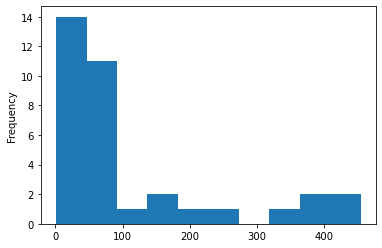

In [15]:
df_clean.loc[df_clean.connection != '500+', 'connection'].astype('int').plot(kind='hist');

We will bin every 50 connections.

In [16]:
# Create bins and labels for increments of 2 minutes
bins = [50 * x for x in range(12)]
labels = ['0-50conn', '51-100conn', '101-150conn', '151-200conn', '201-250conn', 
          '251-300conn', '301-350conn', '351-400conn', '401-450conn', '451-500conn', '500+conn']

# Enumerate '500+' to '501' for binning
df_clean.loc[df_clean.connection == '500+', 'connection'] = 501

# Binning
df_clean['connection_binned'] = pd.cut(df_clean.connection.astype('int'), 
                                       bins=bins, labels=labels, include_lowest=True)

df_clean.connection_binned.value_counts(sort=False)

0-50conn       17
51-100conn      8
101-150conn     1
151-200conn     2
201-250conn     1
251-300conn     1
301-350conn     1
351-400conn     1
401-450conn     2
451-500conn     1
500+conn       18
Name: connection_binned, dtype: int64

Most candidates have few (< 50) or many (> 500) connections. We will come back to this later.

#### Now the main feature, 'job_title'

First, notice that we have a number of acronyms. We will expand these into full expressions, where possible/needed.

In [17]:
# Tokenize 'job_title' so we can look for acronyms
acro_test = df_clean.job_title.apply(nlp)

# Grab all words that are entirely uppercase (i.e., the acronym candidates)
possible_acronyms = []
for r in acro_test:
    pa = [a for a in r if a.is_upper == True]
    possible_acronyms.append(pa)

# Flatten list of possible acronyms
possible_acronyms = [item.text for sublist in possible_acronyms for item in sublist]
' '.join(set(possible_acronyms))

'CSR GPHR EPIK JTI C.T. CHRO SVP EY HRIS ENGIE SPHR MES GIS RRP HR'

In [55]:
# Define the acronyms above, and add a few more that might be generated by data augmentation. 
# In practice, we also could add/import a lengthy list of common job-related acronyms from an external resource.
acro_dict = {'CHRO': 'Chief Human Resources Officer', 'CSR': 'Corporate and Social Responsibility', 
             'GIS': 'Geographic Information System', 'GPHR': 'Global Professional in Human Resources', 
             'HR': 'Human Resources', 'HRIS': 'Human Resources Information System', 
             'MES': 'Manufacturing Execution System', 'SPHR': 'Senior Professional in Human Resources', 
             'SVP': 'Senior Vice President', 'VP': 'Vice President', 
             'CEO': 'Chief Executive Officer', 'CTO': 'Chief Technology Executive', 
             'MBA': 'Master of Business Administration', 'MS': 'Master of Science', 
             'PhD': 'Doctor of Philosophy', 'PHD': 'Doctor of Philosophy',
             'phd': 'doctor of philosophy',  
             'BA': 'Bachelor of Science', 'BS': 'Bachelor of Arts'}

# For replacing acronyms with full text inside of spaCy doc
def acro_expand(doc):
    doc = nlp(doc)
    lst = [t.text if t.text not in acro_dict.keys() else acro_dict[t.text] for t in doc]
    return ' '.join(lst)

Other text cleaning and NLP utilities:

In [19]:
# For expanding contractions
def expand_contraction(doc):
    return contractions.fix(doc)

# For making lowercase and removing puncuation and special characters
punc = "!#$%&()*+,-./:;<=>?@[\\]^_`{|}~'\""
def case_punc(doc):
    doc = doc.lower()
    return (''.join(char if char not in punc else ' ' for char in doc))

# For removing extra whitespace, tab, newline
def remove_extraw_t_n(doc):
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', doc).strip()

# Define stopwords (taken from spaCy)
stopw = nlp.Defaults.stop_words

# For convert words (minus the stopwords) to lemma
def word_to_lemma(doc):
    filtered=[]
    for t in nlp(doc):
        if t.is_stop==False:
            filtered.append(t.lemma_)
    return ' '.join(lem for lem in filtered)

# For removing 1-2 letter words not on stopword list (spurious objects from tokenization or data augmentation)
def drop_1_2_char(doc):
    return ' '.join([w for w in doc.split() if len(w)>2])

In [20]:
# Preprocess 

# Remove acronyms
df_clean['job_preprocessed'] = df_clean.job_title.apply(acro_expand)
# Expand contractions (if any)
df_clean['job_preprocessed'] = df_clean.job_preprocessed.apply(expand_contraction)
# Make lowercase and remove punctuation
df_clean['job_preprocessed'] = df_clean.job_preprocessed.apply(case_punc)
# Remove extra whitespace, tabs, newlines
df_clean['job_preprocessed'] = df_clean.job_preprocessed.apply(remove_extraw_t_n)

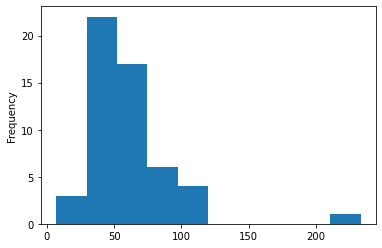

In [21]:
# Check distribution of 'job_preprocessed' lengths
df_clean['job_preprocessed'].apply(len).plot(kind='hist');

Most job titles are distributed together. The 1 really long one contained many acronyms that were expanded, and the shortest 1 is for a student.

In [37]:
maxi = df_clean['job_preprocessed'].apply(len).argmax()
print(df_clean['job_preprocessed'].iloc[maxi])
print()
mini = df_clean['job_preprocessed'].apply(len).argmin()
print(df_clean['job_preprocessed'].iloc[mini])

senior vice president chief human resources officer marketing communications corporate and social responsibility officer engie houston the woodlands energy global professional in human resources senior professional in human resources

student


Now these features are ready to be augmented, but first, we will instantiate our vectorizers.

## Vectorization

We will try 3 different feature sets.
1. Bag of words (BOW) - provided by sklearn
2. TFIDF - provided by sklearn
3. Averge word vectors for each 'job_title' using static word vectors in the loaded spaCy model.

First, BOW and TFIDF:

In [38]:
# We use stopwords from spaCy and make text lowercase
countv = CountVectorizer(stop_words=stopw, lowercase=True)#, ngram_range=(1, 3))
tfidf = TfidfVectorizer(stop_words=stopw, lowercase=True)#, ngram_range=(1, 3))

Third, we use word vectors.

In [39]:
# Define sklearn-compatible transformer
class WordVectorTransformer(TransformerMixin, BaseEstimator):
    # spaCy model
    def __init__(self, model="en_core_web_lg"):
        self.model = model
    # It doesn't actually do anything with fit
    def fit(self, X, y=None):
        return self
    # Transform text data (a list of documents) into average word vector
    def transform(self, X):
        nlp = spacy.load(self.model)
        return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X])
    
# Instantiate and transform data
wordvec_tra = WordVectorTransformer()

## Data Augmentation

We need to augment the dataset in order to tackle this problem. We will do this in 2 ways.

1. Add some examples of 'job_title' (i.e., professional bios) obtained through webscraping - this will roughly double the dataset
2. Generate new data from the doubled dataset using the NLPAUG library - the end result will roughly increase the original dataset twenty-fold.

For the latter, we will generate new examples through 2 subsequent transformations:  
i) contextual word embedding-based *insertion* on 20% of the original text,  
ii) contextual word embedding-based *substitution* on 20% of the augmented text.

We begin with webscraping.

In [40]:
# url with some data
url = ('https://sg.indeed.com/career-advice/career-development/short-professional-bio-examples?aceid=&gclid=CjwKCAjw8sCRBhA6EiwA6_IF4XUAqFhrclK7fgdcjKxUthXjlZNAc1qiUWOR_E_prH1IprNH2C0BBxoCXuIQAvD_BwE')

# Open webpage
page = urlopen(url)

# Read relevant html excerpt from the webpage
html_bytes = page.read()
html = html_bytes.decode('utf-8')
start_index = html.find('Here are 40 two-sentence short professional bio examples to help you write your own:')
end_index = html.find('ordered-list')
examples = html[start_index: end_index]

# List of 40 'job_title' examples found from url excerpt
example_list = re.findall(r'\"value\":\"\\\"(.+?).\\\"\",\"nodeType\"', examples)


# Now grab cities from somewhere...to be added to data later

# url with some data
url2 = ('https://www.infoplease.com/us/cities/top-50-cities-us-population-and-rank')

# Open webpage
page2 = requests.get(url2)

# Parse
soup = BeautifulSoup(page2.text, 'lxml')

# Table info
table = soup.find('table', id='')

# Table column names
headers = []
for i in table.find_all('th'):
    title = i.text
    headers.append(title)

# Write cities to dataframe
cities = pd.DataFrame(columns=headers)
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [i.text for i in row_data]
    length = len(cities)
    cities.loc[length] = row

In [42]:
# Function to anonymize (remove name from beginning of) each example
def anonymize(doc):
    temp = doc.split()
    return ' '.join([w for w in temp[:5] if not w[0].isupper()]) + ' ' + ' '.join([w for w in temp[5:]])

# Create list of examples
examples_to_add = [anonymize(e) for e in example_list]

# Make index different from original dataset and put into dataframe
new_index = list(range(len(df_clean), len(df_clean) + len(examples_to_add)))
examples_df = pd.DataFrame(data=examples_to_add, index=new_index, columns=['job_preprocessed'])

# Preprocess
examples_df['job_preprocessed'] = examples_df.job_preprocessed.apply(acro_expand)
examples_df['job_preprocessed'] = examples_df.job_preprocessed.apply(expand_contraction)
examples_df['job_preprocessed'] = examples_df.job_preprocessed.apply(case_punc)
examples_df['job_preprocessed'] = examples_df.job_preprocessed.apply(remove_extraw_t_n)

print(f'We are adding these {len(examples_to_add)} examples to our dataset:')
pd.set_option('max_colwidth', 200)
display(examples_df)
pd.reset_option('max_colwidth')

We are adding these 40 examples to our dataset:


,job_preprocessed
53,and recently graduated with an advanced diploma from smith secondary school i m seeking an internship where i can apply my skills in content creation and increase my experience in digital marketing
54,and a recent college graduate with a bachelor s degree in web design i m seeking a full time opportunity where i can employ my programming skills
55,and passionate about writing engaging content for businesses i specialise in topics like technology travel and food
56,and passionate about social justice i m currently working as an assistant for martin law
57,and graduated from state university in may 2020 i m interning as a grant writer and practising research and writing every day
58,and a farmer i m passionate about community supported agriculture and sustainability
59,and manage a small cafe i m passionate about making delicious food for others
60,and seeking a position as an architect i have extensive experience in civil engineering and computer aided design
61,and love helping people start their own businesses i work as a business consultant at rosewood consulting
62,and can help you with all your information technology needs i m certified in cybersecurity and networks


We will create multiple duplicates for 5 of the examples above in order to generate multiple clusters. We intentionally keep index=74 to add to the HR pool of candidates (majority group in our original dataset), but the other 4 will be chosen randomly. Since our original dataset is dominated by 1 theme (HR), our augmentation approach should yield something around 5 clusters in total.

In [43]:
# Array of 4 random rows to duplicate
dups = np.random.randint(53, 92, 4)
# Check if index=74
mask = dups == 74
c = np.count_nonzero(mask)
# Replace 74 with 'not 74'
while c > 0:
    np.where(dups == 74, np.random.randint(53, 92, 1), dups)
    # Recheck if a 74 is present
    mask = dups == 74
    c = np.count_nonzero(mask)

# Add index=74 to get 5 rows to duplicate
dups = np.append(dups, [74])

# Dataframe of rows to duplicate
dups_df = examples_df.loc[dups, :]

# Upsample 19 times (plus original, makes 20x increase of those 5 rows)
dups_df = pd.concat([dups_df]*19)

# Combine with other examples
examples_df_withdups = pd.concat([examples_df, dups_df])

# Now combine original dataset and scraped dataset with duplicates (for augmentation)
df_clean_new_withdups = pd.concat([df_clean, examples_df_withdups])
# Also combine original and scraped datasets without duplicates (to be appended to augmented dataset)
df_clean_new = pd.concat([df_clean, examples_df])

# Set 'id' and 'fit' to zero for scraped data
df_clean_new_withdups['id'].fillna(0, inplace=True)
df_clean_new_withdups['fit'].fillna(0, inplace=True)
df_clean_new['id'].fillna(0, inplace=True)
df_clean_new['fit'].fillna(0, inplace=True)
# Set to integer
df_clean_new['id'] = df_clean_new.id.astype(int)

Now the augmentation.

In [44]:
# Load model for synonyms
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# Instantiate character augmenter
# aug_typo = nac.KeyboardAug(aug_char_max=1, aug_word_max=2)

# Instantiate word augmenter via synonym substitution
# aug_syno = naw.SynonymAug(aug_src='wordnet', aug_max=5, aug_p=0.3, stopwords=stopw)

# Instantiate 2 contextual word embedding augmenters via distilled BERT model
aug_bert1 = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='insert',
                                      aug_p=0.2, stopwords=stopw, top_k=40)
aug_bert2 = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='substitute', 
                                      aug_p=0.2, stopwords=stopw, top_k=40)

# Flow sequence of data augmentation
aug_seq = naf.Sequential([aug_bert1, aug_bert2])

Now, we upsample/augment our dataset.

In [45]:
# Prepare lists for 'id' and augmented data
id_data = []
aug_data = []

# Number of new data samples
n_aug = 9
    
# Data augmentation
for row in tqdm(df_clean_new_withdups.index):
    the_id = int(df_clean_new_withdups.id.iloc[row])
    the_text = df_clean_new_withdups.job_preprocessed.iloc[row]
    aug_list = aug_seq.augment(the_text, n=n_aug, num_thread=4)
    # Keep record of 'id', but distinguish from original data by adding 1000
    id_data.append(the_id + 1000)
    aug_data.append(aug_list)

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [10:43<00:00,  3.42s/it]


In [52]:
# Flatten augmented data
flat_list = [item for sublist in aug_data for item in sublist]
# Get indices from aug_data for mapping id_data accordingly (if desired - otherwise disregard)
index_for_id = [ind // n_aug for ind, x in enumerate(flat_list)]
# 'Flatten' indices for augmented data
flat_list_id = [id_data[x] for x in index_for_id]

# Enter augmented data into dataframe
df_aug = pd.DataFrame([item for item in flat_list], columns=['job_augmented'])

# Add 'id' to dataframe
df_aug['id'] = np.asarray(flat_list_id).astype(int)

Now we can generate our 3 datasets (BOW, TFIDF, spaCy vectors) starting with the augmented data.

In [137]:
# Re-preprocess to remove any oddities showing up from BERT 
df_aug['job_preprocessed'] = df_aug.job_augmented.apply(acro_expand)
df_aug['job_preprocessed'] = df_aug.job_preprocessed.apply(case_punc)
df_aug['job_preprocessed'] = df_aug.job_preprocessed.apply(remove_extraw_t_n)
df_aug['job_preprocessed'] = df_aug.job_preprocessed.apply(drop_1_2_char)

# Add a location and random number of connections
df_aug['job_plus'] = [r + f' {cities.iloc[np.random.randint(0, 50), 1]}'
                                   + f' {str(np.random.randint(0, 501))}conn' 
                                   for r in df_aug.job_preprocessed]

# Oh, let's not forget to add 'location' and 'connection' to 'job_title' in df_clean_new!!
df_clean_new['job_plus'] = (df_clean_new.job_preprocessed + ' ' + locations.txt1.str.lower() 
                        + ' ' + locations.txt2.str.lower()
                        + ' ' + df_clean_new.connection_binned.astype(str))
# And fill in NANs
df_clean_new['job_plus'] = np.where(df_clean_new['job_title'].isna(), 
                                    [r + f' {cities.iloc[np.random.randint(0, 50), 1]}'
                                     + f' {str(np.random.randint(0, 501))}conn' 
                                     for r in df_clean_new.job_preprocessed],  
                                    [r for r in df_clean_new.job_plus])

# Final cleanup
df_aug['job_plus'] = df_aug.job_plus.apply(case_punc)
df_aug['job_plus'] = df_aug.job_plus.apply(remove_extraw_t_n)
df_aug['job_plus'] = df_aug.job_plus.apply(drop_1_2_char)
df_clean_new['job_plus'] = df_clean_new.job_plus.apply(case_punc)
df_clean_new['job_plus'] = df_clean_new.job_plus.apply(remove_extraw_t_n)
df_clean_new['job_plus'] = df_clean_new.job_plus.apply(drop_1_2_char)

# Examples
print('Example from df_clean_new:')
display(df_clean_new['job_plus'].iloc[20])
print('Example from df_aug:')
display(df_aug['job_plus'].iloc[20])

# We also will lemmatize the final clean(_new) and augmented text (doesn't affect spaCy vectors, only BOW and TFIDF)
df_clean_new['lemmas'] = df_clean_new.job_plus.apply(word_to_lemma)
df_aug['lemmas'] = df_aug.job_plus.apply(word_to_lemma)

# Save clean and augmented data
df_clean_new.to_csv('original_scraped.csv')
df_aug.to_csv('augmented.csv')

# Add original examples to augmented data and save lemmas
data = pd.concat([df_clean_new.lemmas, df_aug.lemmas]).reset_index(drop=True)
data.to_csv('lemmas_for_X.csv')

# BOW data
X_bow = countv.fit_transform(data)
print('X_bow shape:', X_bow.shape, '\n')

# TFIDF data
X_tfidf = tfidf.fit_transform(data)
print('X_tfidf shape:', X_tfidf.shape, '\n')

# spaCy vector data
X_wv = wordvec_tra.fit_transform(data)
print('X_wv shape:', X_wv.shape)

Example from df_clean_new:


'business management major and aspiring human resources manager monroe louisiana 50conn'

Example from df_aug:


'aspiring human resources development officer sacramento california 400conn'

X_bow shape: (1785, 3106) 

X_tfidf shape: (1785, 3106) 

X_wv shape: (1785, 300)


## Clustering

Due to the high dimensionality of our datasets, we use PCA to aid in visualizing clusters.  
(Although we could have performed PCA prior to clustering, we chose to do it aftward since much of the data variance was not described by the principal components.)

We will attempt clustering using 4 different algorithms: 
1. K Means - because it's easy to try and simple to interpret when it works
2. Bayesian Gaussian Mixture - because it's more flexible than KMeans by assuming ellipsoidal (vs. spherical) clusters
3. Agglomerative Clustering - because it provides a nice graphic (dendrogram) to interpret and doesn't assume cluster shapes
4. Spectral Clustering - because it also doesn't assume cluster shapes, but rather relies on data connectivity.

#### PCA for forthcoming plots

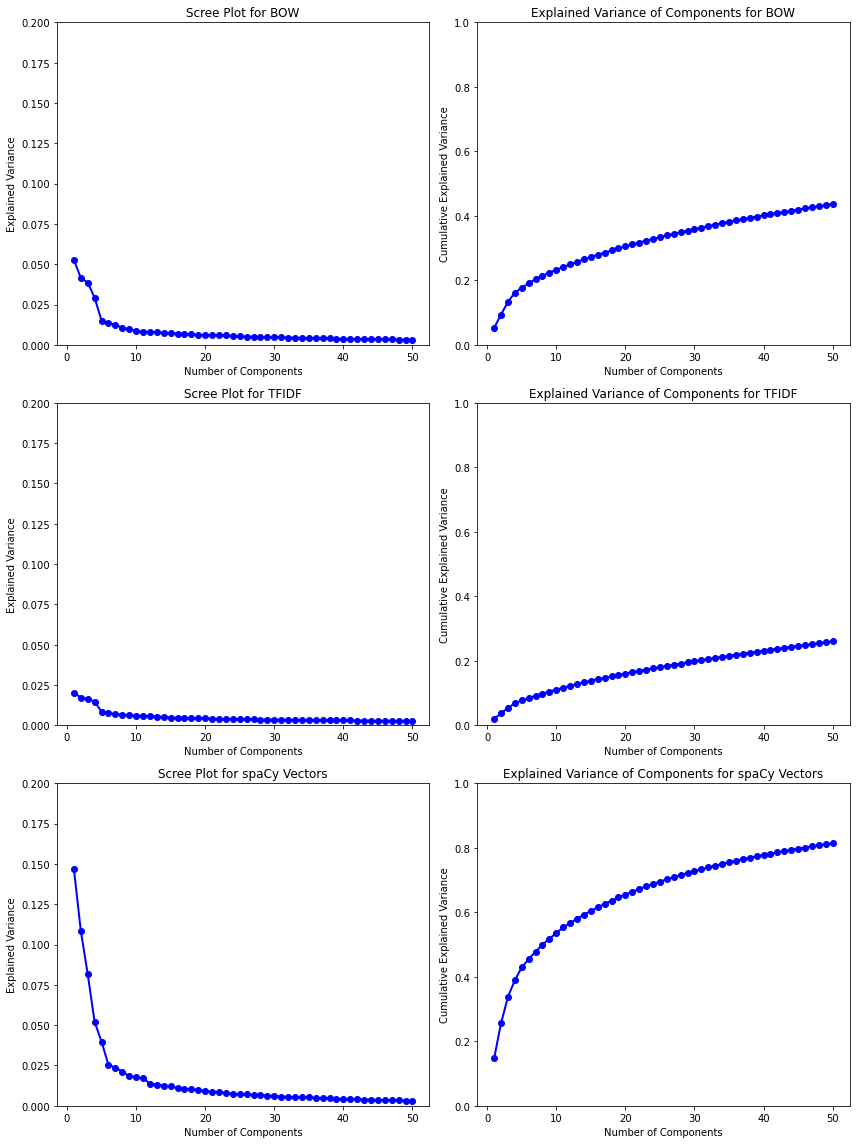

In [138]:
# PCA for BOW, TFIDF, and spaCy vectors to be used for visualization later
pca_bow = PCA(n_components=50, random_state=ranseed)
pca_bow_fit = pca_bow.fit(X_bow.todense())
pca_tfidf = PCA(n_components=50, random_state=ranseed)
pca_tfidf_fit = pca_tfidf.fit(X_tfidf.todense())
pca_wv = PCA(n_components=50, random_state=ranseed)
pca_wv_fit = pca_wv.fit(X_wv)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 16))

PC_values = np.arange(pca_bow_fit.n_components_) + 1
ax1.plot(PC_values, pca_bow_fit.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
ax1.set_title('Scree Plot for BOW')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Explained Variance')
ax1.set_ylim(0, 0.2)

ax2.plot(PC_values, pca_bow_fit.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue')
ax2.set_title('Explained Variance of Components for BOW')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_ylim(0, 1)

PC_values = np.arange(pca_tfidf_fit.n_components_) + 1
ax3.plot(PC_values, pca_tfidf_fit.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
ax3.set_title('Scree Plot for TFIDF')
ax3.set_xlabel('Number of Components')
ax3.set_ylabel('Explained Variance')
ax3.set_ylim(0, 0.2)

ax4.plot(PC_values, pca_tfidf_fit.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue')
ax4.set_title('Explained Variance of Components for TFIDF')
ax4.set_xlabel('Number of Components')
ax4.set_ylabel('Cumulative Explained Variance')
ax4.set_ylim(0, 1)

PC_values = np.arange(pca_wv_fit.n_components_) + 1
ax5.plot(PC_values, pca_wv_fit.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
ax5.set_title('Scree Plot for spaCy Vectors')
ax5.set_xlabel('Number of Components')
ax5.set_ylabel('Explained Variance')
ax5.set_ylim(0, 0.2)

ax6.plot(PC_values, pca_wv_fit.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue')
ax6.set_title('Explained Variance of Components for spaCy Vectors')
ax6.set_xlabel('Number of Components')
ax6.set_ylabel('Cumulative Explained Variance')
ax6.set_ylim(0, 1)

plt.tight_layout()
plt.show()

Our BERT augmentation scheme seems to have generated a great deal of variance/noise that cannot be captured by even the first 50 principal components for BOW and TFIDF, but PCA will still serve us well for visualization.

For any given number of components, the variance is most fully explained for the spaCy vector model. This may be due to how data augmentation was carried out (using contextual word embeddings). The word insertions and substitutions will not change the similarities captured by spaCy word vectors as much as the word counts (normalized or not) of BOW and TFIDF vectors.

In [139]:
# Choose number of components based on scree plot
n_co = 4

# Finalize PCA for BOW and spaCy vectors
pca_bow = PCA(n_components=n_co, random_state=ranseed)
scores_pca_bow = pca_bow.fit_transform(X_bow.todense())
pca_tfidf = PCA(n_components=n_co, random_state=ranseed)
scores_pca_tfidf = pca_tfidf.fit_transform(X_tfidf.todense())
pca_wv = PCA(n_components=n_co, random_state=ranseed)
scores_pca_wv = pca_wv.fit_transform(X_wv)

#### Clustering

In [140]:
# Use KMeans to cluster jobs
rg = range(2, 20, 1)
SSE_bow = []
score_bow = []
SSE_tfidf = []
score_tfidf = []
SSE_wv = []
score_wv = []
for cluster in tqdm(rg):
    
    kmeans_bow = KMeans(n_clusters=cluster, random_state=ranseed)
    lab_bow = kmeans_bow.fit(X_bow)
    SSE_bow.append(lab_bow.inertia_)
    score_bow.append(silhouette_score(X_bow, lab_bow.labels_))
    
    kmeans_tfidf = KMeans(n_clusters=cluster, random_state=ranseed)
    lab_tfidf = kmeans_tfidf.fit(X_tfidf)
    SSE_tfidf.append(lab_tfidf.inertia_)
    score_tfidf.append(silhouette_score(X_tfidf, lab_tfidf.labels_))
    
    kmeans_wv = KMeans(n_clusters=cluster, random_state=ranseed)
    lab_wv = kmeans_wv.fit(X_wv)
    SSE_wv.append(lab_wv.inertia_)
    score_wv.append(silhouette_score(X_wv, lab_wv.labels_))
    
# Put data into dataframe
frame = pd.DataFrame({'Cluster': rg, 'SSE_bow': SSE_bow, 'sil_score_bow': score_bow, 
                      'SSE_tfidf': SSE_tfidf, 'sil_score_tfidf': score_tfidf, 
                      'SSE_wv': SSE_wv, 'sil_score_wv': score_wv})

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:42<00:00,  9.02s/it]


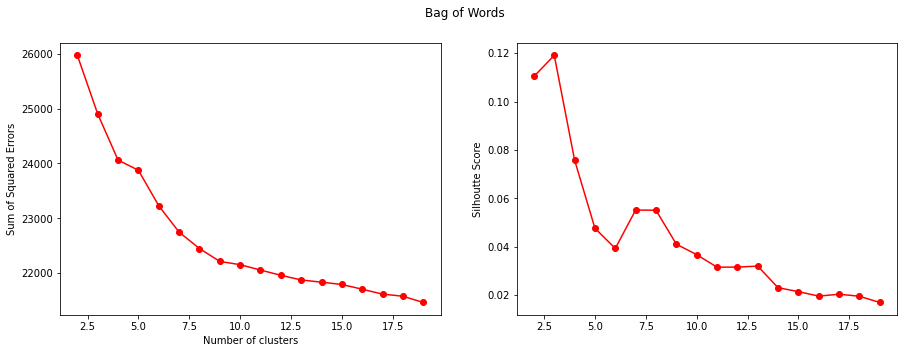

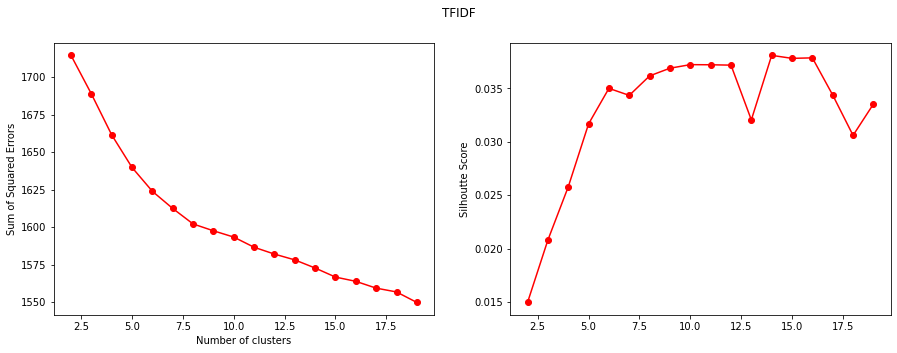

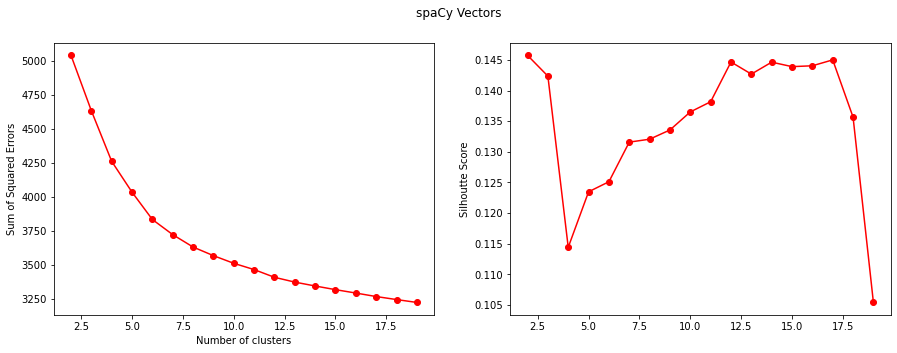

In [141]:
# Plot error and silhoutte score for BOW
fig, ax = plt.subplots(1, 2, figsize=(15, 5), )
ax[0].plot(frame['Cluster'], frame['SSE_bow'], 'ro-')
ax[0].set_ylabel('Sum of Squared Errors')
ax[0].set_xlabel('Number of clusters')
ax[1].plot(frame['Cluster'], frame['sil_score_bow'], 'ro-')
ax[1].set_ylabel('Silhoutte Score')
ax[1].grid(b=False)
fig.suptitle('Bag of Words')
plt.show()

# Plot error and silhoutte score for TFIDF
fig, ax = plt.subplots(1, 2, figsize=(15, 5), )
ax[0].plot(frame['Cluster'], frame['SSE_tfidf'], 'ro-')
ax[0].set_ylabel('Sum of Squared Errors')
ax[0].set_xlabel('Number of clusters')
ax[1].plot(frame['Cluster'], frame['sil_score_tfidf'], 'ro-')
ax[1].set_ylabel('Silhoutte Score')
ax[1].grid(b=False)
fig.suptitle('TFIDF')
plt.show()

# Plot error and silhoutte score for spaCy vectors
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(frame['Cluster'], frame['SSE_wv'], 'ro-')
ax[0].set_ylabel('Sum of Squared Errors')
ax[0].set_xlabel('Number of clusters')
ax[1].plot(frame['Cluster'], frame['sil_score_wv'], 'ro-')
ax[1].set_ylabel('Silhoutte Score')
ax[1].grid(b=False)
fig.suptitle('spaCy Vectors')
plt.show()

The number of clusters based on elbow method and silhoutte score is between ~4 and ~7 for both BOW and TFIDF, and perhaps the same for spaCy vectors.

The silhoutte score magnitude isn't great (on a scale of -1 to 1), but the PCA-based plots below reveal clear clusters (note: we got silhoutte scores between 0.2 and 0.5 for *clustering after PCA*).

Below we plot the first 2 principal components versus each other for the 3 encodings.

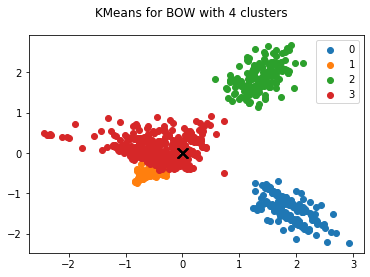

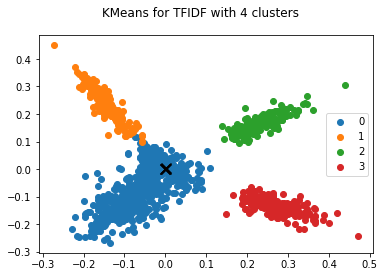

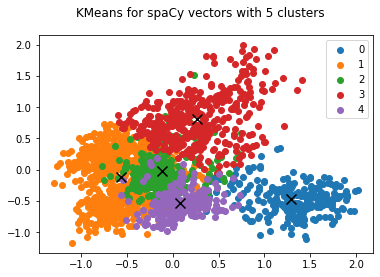

In [152]:
# Number of clusters
n_cl = 4
# Principal components to plot
first = 0
second_or_later = 1

# KM cluster labels for BOW
kmeans_bow = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_bow.fit_predict(X_bow)
centers = np.array(kmeans_bow.cluster_centers_)
uniq = np.unique(label)

# Plot principal components
plt.figure()
# Clusters
for u in uniq:
    plt.scatter(scores_pca_bow[label == u, first], scores_pca_bow[label == u, second_or_later], label=u)
# Cluster centroids
plt.scatter(centers[:, first], centers[:, second_or_later], marker="x", s=100, color='k')
plt.suptitle(f'KMeans for BOW with {n_cl} clusters')
plt.legend()
plt.show()


# Number of clusters
n_cl = 4

# KM cluster labels for TFIDF
kmeans_tfidf = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_tfidf.fit_predict(X_tfidf)
centers = np.array(kmeans_tfidf.cluster_centers_)
uniq = np.unique(label)

# Plot principal components
plt.figure()
# Clusters
for u in uniq:
    plt.scatter(scores_pca_tfidf[label == u, first], scores_pca_tfidf[label == u, second_or_later], label=u)
# Cluster centroids
plt.scatter(centers[:, first], centers[:, second_or_later], marker="x", s=100, color='k')
plt.suptitle(f'KMeans for TFIDF with {n_cl} clusters')
plt.legend()
plt.show()


# Number of clusters
n_cl = 5

# KM cluster labels for spaCy vectors
kmeans_pca_wv = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_pca_wv.fit_predict(scores_pca_wv)
centers = np.array(kmeans_pca_wv.cluster_centers_)
uniq = np.unique(label)

# Plot principal components
plt.figure()
# Clusters
for u in uniq:
    plt.scatter(scores_pca_wv[label == u, first], scores_pca_wv[label == u, second_or_later], label=u)
# Cluster centroids
plt.scatter(centers[:, first], centers[:, second_or_later], marker="x", s=100, color='k')
plt.suptitle(f'KMeans for spaCy vectors with {n_cl} clusters')
plt.legend()
plt.show()

Clusters are better visualized in 3d:

In [153]:
# Number of clusters
n_cl = 4
# Principal components to plot
first = 0
second_or_later = 1
third = 2

# KM cluster labels for BOW
kmeans_bow = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_bow.fit_predict(X_bow)
centers = np.array(kmeans_bow.cluster_centers_)
uniq = np.unique(label)

# Plot first 3 components by cluster in 3d

cluster3d = go.Figure()

for u in uniq:

    cluster3d.add_trace(go.Scatter3d(x=scores_pca_bow[label == u, first], 
                                y=scores_pca_bow[label == u, second_or_later], 
                                z=scores_pca_bow[label == u, third], 
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(u + 1)))


cluster3d.update_layout(width=800, height=800, autosize=True, showlegend=True,
                        title_text='BOW Clusters', 
                   scene=dict(xaxis=dict(title='PC1', titlefont_color='black'),
                                yaxis=dict(title='PC2', titlefont_color='black'),
                                zaxis=dict(title='PC3', titlefont_color='black')),
                   font = dict(family="Gilroy", color='black', size=12))

Image for plot above:
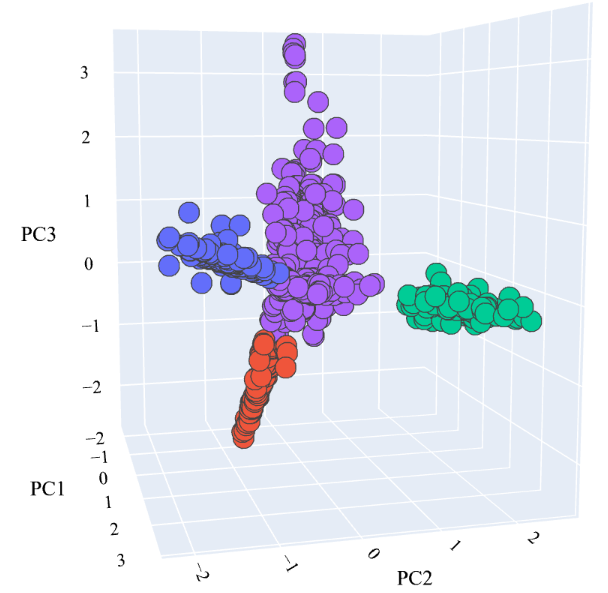

In [154]:
# Number of clusters
n_cl = 4
# Principal components to plot
first = 0
second_or_later = 1
third = 2

# KM cluster labels for TFIDF
kmeans_tfidf = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_tfidf.fit_predict(X_tfidf)
centers = np.array(kmeans_tfidf.cluster_centers_)
uniq = np.unique(label)

# Plot first 3 components by cluster in 3d

cluster3d = go.Figure()

for u in uniq:

    cluster3d.add_trace(go.Scatter3d(x=scores_pca_tfidf[label == u, first], 
                                y=scores_pca_tfidf[label == u, second_or_later], 
                                z=scores_pca_tfidf[label == u, third], 
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(u + 1)))


cluster3d.update_layout(width=800, height=800, autosize=True, showlegend=True,
                        title_text='TFIDF Clusters', 
                   scene=dict(xaxis=dict(title='PC1', titlefont_color='black'),
                                yaxis=dict(title='PC2', titlefont_color='black'),
                                zaxis=dict(title='PC3', titlefont_color='black')),
                   font = dict(family="Gilroy", color='black', size=12))

Image for plot above:
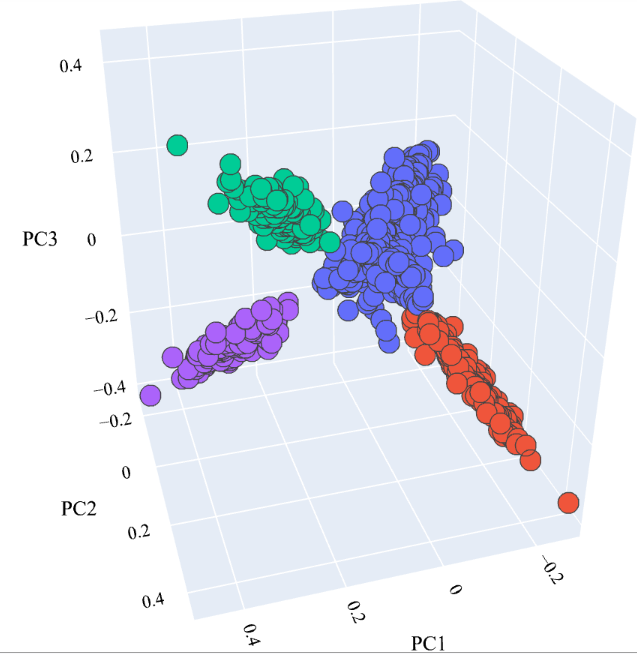

In [155]:
# Number of clusters
n_cl = 5
# Principal components to plot
first = 0
second_or_later = 1
third = 2

# KM cluster labels for spaCy vectors
kmeans_wv = KMeans(n_clusters=n_cl, random_state=ranseed)
label = kmeans_wv.fit_predict(X_wv)
centers = np.array(kmeans_wv.cluster_centers_)
uniq = np.unique(label)

# Plot first 3 components by cluster in 3d

cluster3d = go.Figure()

for u in uniq:

    cluster3d.add_trace(go.Scatter3d(x=scores_pca_wv[label == u, first], 
                                y=scores_pca_wv[label == u, second_or_later], 
                                z=scores_pca_wv[label == u, third], 
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(u + 1)))


cluster3d.update_layout(width=800, height=800, autosize=True, showlegend=True,
                        title_text='spaCy Vector Clusters', 
                   scene=dict(xaxis=dict(title='PC1', titlefont_color='black'),
                                yaxis=dict(title='PC2', titlefont_color='black'),
                                zaxis=dict(title='PC3', titlefont_color='black')),
                   font = dict(family="Gilroy", color='black', size=12))

Image for plot above:
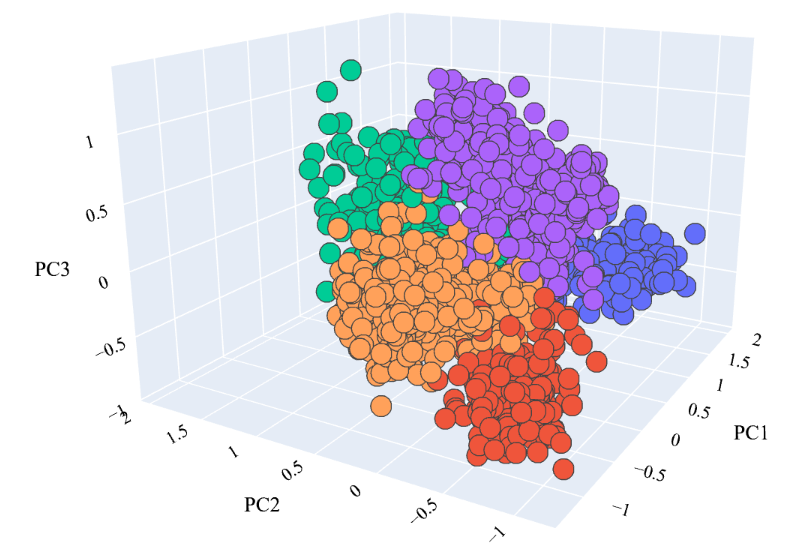

Of these, TFIDF has the most distinct clusters (with n=4). Averaged word vectors give the least separation. We will drop the spaCy vectors from here on out.

In [156]:
# Try BayesianGaussianMixture in place of KMeans

# Use a larger number of clusters and allow weights to be reduced to small values for excess clusters.
n_cl = 7

BGM_bow = BayesianGaussianMixture(n_components=n_cl, random_state=ranseed).fit(X_bow.todense())
print(f'Weights for BOW with {n_cl} clusters: {np.round(BGM_bow.weights_, 3)}')

BGM_tfidf = BayesianGaussianMixture(n_components=n_cl, random_state=ranseed).fit(X_tfidf.todense())
print(f'Weights for TFIDF with {n_cl} clusters: {np.round(BGM_tfidf.weights_, 3)}')

# Cluster labels
BGM_bow_pred = BGM_bow.predict(X_bow.todense())
BGM_tfidf_pred = BGM_tfidf.predict(X_tfidf.todense())

Weights for BOW with 7 clusters: [0.018 0.099 0.278 0.009 0.091 0.486 0.018]
Weights for TFIDF with 7 clusters: [0.102 0.33  0.108 0.1   0.101 0.157 0.101]


Based on the largest weights, BOW has 4 prominent clusters while TFIDF has at least 7. For brevity, we won't go through all the visualizations here, but I want to note that KMeans looks more convincing than BGM.

Let's investigate the dendrogram for hierarchical clustering.

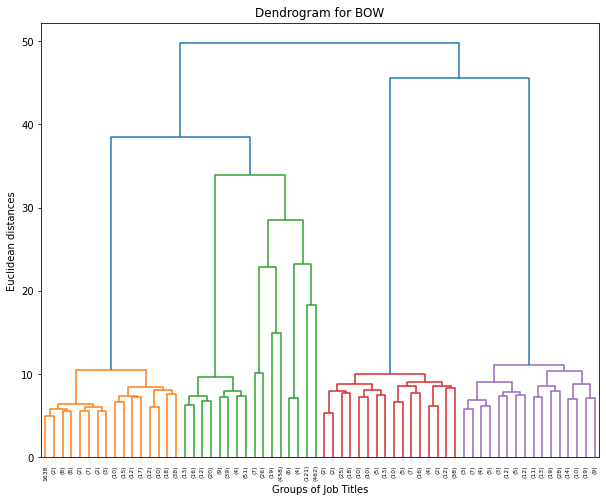

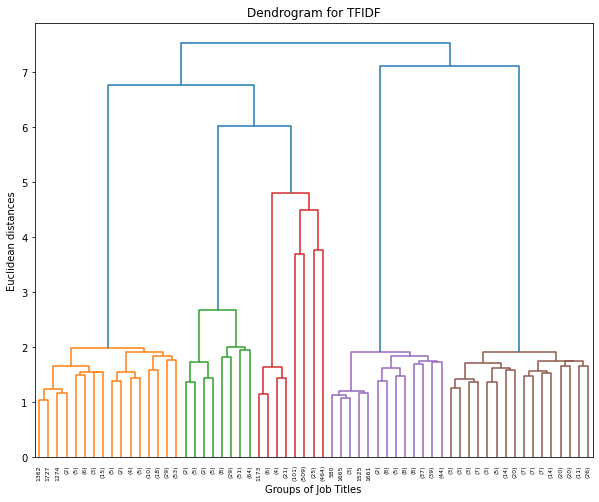

In [157]:
# Linkage matrix for AgglomerativeClustering - BOW
Z_bow = sch.linkage(X_bow.todense(), method='ward')
# Plot
plt.figure(figsize=(10,8))
dendrogram = sch.dendrogram(Z_bow, p=5, truncate_mode='level')
plt.title('Dendrogram for BOW')
plt.xlabel('Groups of Job Titles')
plt.ylabel('Euclidean distances')
plt.show()

# Linkage matrix for AgglomerativeClustering - BOW
Z_tfidf = sch.linkage(X_tfidf.todense(), method='ward')
# Plot
plt.figure(figsize=(10,8))
dendrogram = sch.dendrogram(Z_tfidf, p=5, truncate_mode='level')
plt.title('Dendrogram for TFIDF')
plt.xlabel('Groups of Job Titles')
plt.ylabel('Euclidean distances')
plt.show()

It looks like there are 3-6 clusters for BOW and 4-5 for TFIDF.

In [159]:
# Hierarchical clustering
n_cl = 4
AC_bow = AgglomerativeClustering(n_clusters=n_cl, linkage='ward').fit(X_bow.todense())
n_cl = 4
AC_tfidf = AgglomerativeClustering(n_clusters=n_cl, linkage='ward').fit(X_tfidf.todense())

Again, for brevity we will skip the visualizations, but I will note that they look somewhat like those for KMeans. However, KMeans is cleaner (more well-separated).

In [162]:
# Spectral Clustering
n_cl = 4
SC_bow = SpectralClustering(n_clusters=n_cl, random_state=ranseed).fit(X_bow)
n_cl = 4
SC_tfidf = SpectralClustering(n_clusters=n_cl, random_state=ranseed).fit(X_tfidf)

Spectral clustering yielded inferior results (not visualized here) to KMeans, particularly for BOW (TFIDF was quite comparable).

In the end, we will choose KMeans with n=4 using the TFIDF dataset for this problem. Let's see how the text from these clusters reads.

In [986]:
# Final KM cluster labels for TFIDF
n_tfidf = 4
kmeans_tfidf = KMeans(n_clusters=n_tfidf, random_state=ranseed)
label_tfidf = kmeans_tfidf.fit_predict(X_tfidf)
centers_tfidf = np.array(kmeans_tfidf.cluster_centers_)
uniq_tfidf = np.unique(label_tfidf)

# Dataframe with preprocessed and lemmatized text
final_data = pd.concat([df_clean_new[['id', 'job_plus']], df_aug[['id', 'job_plus']]]).reset_index(drop=True)

# Assign clusters to texts
final_data['cluster_tfidf'] = label_tfidf
    
for c in range(n_tfidf):
    pd.set_option('max_colwidth', 150)
    print(f'Sample from TFIDF Cluster {c}:')
    display(final_data.job_plus[final_data.cluster_tfidf == c].sample(5))
    print()
    pd.reset_option('max_colwidth')

Sample from TFIDF Cluster 0:


821                             passionate about travel and hospitality developed famous safari driver where gained credits about places miami florida 91conn
735     freshman robert stone university has written book and journal outline the three aspects paleolithic egyptian history philadelphia pennsylvania 385...
301                             nortia group increasingly seeking quality human and payroll manpower professionals 408 709 2621 sacramento california 258conn
14                                                                  experienced retail manager and aspiring human resources professional austin texas 100conn
1654                      morgan creates whimsical abstract poses for individuals both couples and young adults she would love paint you austin texas 245conn
Name: job_plus, dtype: object


Sample from TFIDF Cluster 1:


700     and special service employee desperately trying successfully leverage customer service skills more highly challenging management role fresno calif...
1452                   and customer service industry wherein make mission address and solve all customer network industries efficiently houston texas 327conn
1093    and certified customer and certified representative make primary mission resolve and successfully solve sensitive questions efficiently bakersfiel...
1143    and customer complaints service representative make mission quickly resolve and interpret correct customer questions quite effectively tucson ariz...
697              and gifted food supply service service employee looking apply customer service services more diverse workforce market phoenix arizona 64conn
Name: job_plus, dtype: object


Sample from TFIDF Cluster 2:


1583    freelance host for oswald online technologies immensely accomplished programmer and designer using his programming skills cater the increasingly s...
1178    keen web developer for geo mapping technologies remains accomplished programmer and actively enjoys using his computer programmers hopefully contr...
1265    popular personality for oswald technologies also becomes active programmer and happily enjoys using his keyboard skills hopefully contribute the e...
1533    web developer for oswald animated technologies immensely skilled graphic engineer and still enjoys using his skills contribute the imaginative wor...
994     web programming developer for oswald animation technologies ibm technical programmer and also can using his skills contribute the extremely exciti...
Name: job_plus, dtype: object


Sample from TFIDF Cluster 3:


1486    and recent college graduate with bachelor certificate creative computer science essentially seeking full faculty opportunity where can continuousl...
1261    and recent college graduate with design masters plus degrees web design can still seeking full time needed creative opportunity where can quickly ...
1209    and most recent stanford software engineering graduate with doctor philosophy thesis web application seeking full time opportunity where can emplo...
1392    and qualified microsoft college graduate with dual bachelor college degree advanced technology applications offered full employment time opportuni...
1442    and quite recent mba graduate with bachelor honours msc applied web programming seeking full market modelling opportunity where can employ entire ...
Name: job_plus, dtype: object

For the given keywords (HR theme), it looks like we are most interested in cluster 0. Before moving on, let's define a function to get nearest neighbors for any point within a cluster (which we will use for rankings).

The nice part about clustering is that it cuts down on the volume of data that the NN function below operates on. If time becomes an issue, approximate NN calculates or additional cluster (subclusters within a cluster) could be necessary.

In [1266]:
# For locating nearest neighbors
def get_neigh_dist(train, test_row, num_neighbors):
    
    # Sparse to dense
    train = train.todense()
    test_row = test_row.todense()
    
    # Index counter
    r = 0
    
    distances = []
    for train_row in train:
        
        # Compute distance
        dist = np.linalg.norm(test_row - train_row)
        
        # Append tuple of vector, index, and distance
        distances.append((train_row, r, dist))
        
        # Update index
        r += 1
        
    # Sort distances by distance
    distances.sort(key=lambda tup: tup[2])

    neigh_dist = []
    for i in range(num_neighbors):
        neigh_dist.append(distances[i][1:])
    return neigh_dist

## Keyword Search

In [1267]:
# Input 
keywords = 'seeking human resources' # aspiring human resources

# Preprocess
keywords = [word_to_lemma(remove_extraw_t_n(case_punc(expand_contraction(acro_expand(keywords)))))]

# Identify cluster based on TFIDF
kw_tfidf = tfidf.transform(keywords)
kw_cluster_t = kmeans_tfidf.predict(kw_tfidf)
print(f'TFIDF cluster: {kw_cluster_t[0]}')

TFIDF cluster: 0


As suspected, cluster 0 was selected.

## Candidate Rankings

Initial sampling and ranking.

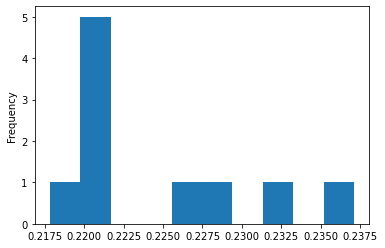

In [1270]:
# Data from cluster
# (reset df index to avoid indexing issues between it and numpy array)
cluster_data = final_data.loc[final_data.cluster_tfidf == kw_cluster_t[0], :].reset_index(drop=True)
X_cl_tfidf = X_tfidf[final_data.cluster_tfidf == kw_cluster_t[0]]

# Sampling from cluster data
num_to_review = 10

# Get nearest neighbors within cluster
indices = np.array(get_neigh_dist(X_cl_tfidf, kw_tfidf, num_to_review)).T[0]
distances = np.array(get_neigh_dist(X_cl_tfidf, kw_tfidf, num_to_review)).T[1]
cluster_sample = cluster_data.iloc[list(indices), :].copy()

# For computing 'fit' probability
def prob_fun(x, avg, std):
    # Probability of normal distribution
    return norm.pdf(x, loc=avg, scale=std)

# Get 'fit' from distances around keyword:
# we assume mean of distribution is zero (distance from keyword), 
# and standard deviation is on the order of the mean of NN distances
cluster_sample['fit'] = prob_fun(distances, 0, np.mean(distances))

# For recording results for each ranking iteration
iterations = cluster_sample.to_numpy()

# Histogram of rankings
cluster_sample.fit.plot(kind='hist');

## Manual Review and Re-ranking

,job_plus,cluster_tfidf,fit
8,seeking human resources human resources information system and generalist positions philadelphia 500 conn,0,0.237113
163,seeking human resources resources human resources society benefits system and support generalist services tulsa oklahoma 107conn,0,0.233151
21,aspiring human resources manager seeking internship human resources houston texas 50conn,0,0.229113
207,seeking human resources skills portland oregon 115conn,0,0.225817
165,seeking comprehensive human resources human data resources policy information officers and technical positions paso texas 323conn,0,0.221166
278,many human resources investment executives seeking internship professional human service houston texas 390conn,0,0.221154
279,aspiring human and resources managers seeking internship human information communication tucson arizona 434conn,0,0.221011
517,seeking human and resources position san diego california 444conn,0,0.220893
47,seeking human resources position las vegas nevada 50conn,0,0.220033
167,seeking human potential for human resources through information system and generalist skills denver colorado 292conn,0,0.217822


Enter the index number of the best candidate: 207


,job_plus,cluster_tfidf,fit
207,seeking human resources skills portland oregon 115conn,0,0.343194
238,human resource services camp luxottica portland oregon 78conn,0,0.217124
199,aspiring human resources professionals student association seeking interdisciplinary agenda portland oregon 467conn,0,0.212608
239,distinguished human resource planning specialist nasa portland oregon 106conn,0,0.211798
227,ieee human capital resources research and recruiting professional portland oregon 434conn,0,0.210732
1154,human resource resource professional has begun career coaching payroll and payroll planning portland oregon 356conn,0,0.207736
456,students seeking employment opportunities within public service service patient training portland oregon 205conn,0,0.205598
1059,successful career resources consulting whom has extensive teaching experience payroll and administration portland oregon 283conn,0,0.203963
555,always about holding them for mutual success portland oregon 483conn,0,0.202060
264,human performance science management generalist siemens inc portland oregon 310conn,0,0.201800


Enter the index number of the best candidate: 1154


,job_plus,cluster_tfidf,fit
1154,human resource resource professional has begun career coaching payroll and payroll planning portland oregon 356conn,0,0.335417
1059,successful career resources consulting whom has extensive teaching experience payroll and administration portland oregon 283conn,0,0.215181
239,distinguished human resource planning specialist nasa portland oregon 106conn,0,0.209526
207,seeking human resources skills portland oregon 115conn,0,0.207647
931,certified resource professional has had professional career payroll and budget administration mesa arizona 429conn,0,0.202354
1172,human resource professional has acquired extensive experience different payroll and payroll companies san antonio texas 453conn,0,0.199605
1057,human development service planning professional has extensive work done payroll and statistics paso texas 464conn,0,0.199541
933,public resource service professional has made extensive experience payroll and payroll operations oakland california 471conn,0,0.199410
1202,human financial management professional has extensive experience both payroll and payroll administration sacramento california 244conn,0,0.198983
898,financial resource services professional has extensive experience providing payroll and payroll business omaha nebraska 213conn,0,0.198710


Enter the index number of the best candidate: 1154
Distributions of nearest neighbors:


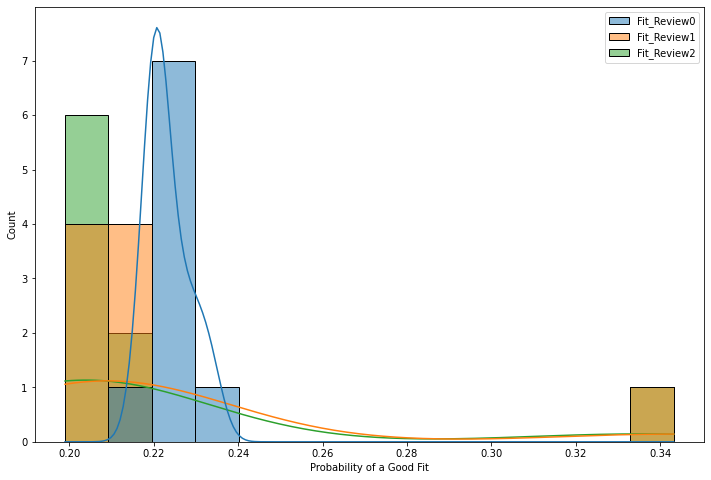

In [1271]:
# Display results
pd.set_option('max_colwidth', 200)
display(cluster_sample.iloc[:, 1:])

# Initialize and loop counter
top_choice = cluster_sample.index[0]
loop = 0

# Initialize manual review
man_review = True
while man_review:
    
    # Manual review
    inp = input('Enter the index number of the best candidate: ')
         
    # Manual review loop stops when best candidate is at top of list
    if int(inp) == top_choice and loop != 0:
        break       
    
    else:
        
        inpu = int(inp)
        
        # Get nearest neighbors
        indices = np.array(get_neigh_dist(X_cl_tfidf, X_cl_tfidf[inpu], num_to_review)).T[0]
        distances = np.array(get_neigh_dist(X_cl_tfidf, X_cl_tfidf[inpu], num_to_review)).T[1]
        
        # Enter rows into dataframe using NN indices
        cluster_sample = cluster_data.iloc[list(indices), :].copy()

        # Compute and enter rankings into dataframe using NN distances from starred candidate
        cluster_sample['fit'] = prob_fun(distances, distances[0], np.mean(distances[1:]))

        # Append new top num_to_review to record iteration
        if iterations.ndim == 2:
            iterations = np.stack((iterations, cluster_sample.sort_values(by='fit').to_numpy()), axis=-1)
        else:
            iterations = np.concatenate((iterations, 
                                         cluster_sample.sort_values(by='fit').to_numpy()
                                         .reshape((num_to_review, 4, 1))), axis=-1)
            
        # Update top choice and loop counter for next iteration
        top_choice = cluster_sample.index[0]
        loop += 1
        
        # Display new top num_to_review
        display(cluster_sample.iloc[:, 1:])
        
pd.reset_option('max_colwidth')

# Write history of 'fit' into dataframe
search_history = pd.DataFrame(iterations[:,-1], dtype='float')
search_history.columns = [f'Fit_Review{c}' for c in search_history.columns]

# Plot histograms from history for neighbors around ideal candidate
print('Distributions of nearest neighbors:')
plt.figure(figsize = (12,8))
g = sns.histplot(search_history.iloc[1:, :], kde=True)
g.set(xlabel='Probability of a Good Fit')
plt.show()

Above we see that there was an initial concentration (blue) around the keywords, where many candidates had a similar probability of being the best fit.

After starring a candidate the distribution separates, giving one individual more likelihood of a good fit over the others.

## Conclusion

We used KMeans clustering to segregate data into 4 clusters based on TFIDF-encoded (and augmented) text concatenated from job title, location, and connnections.

Once the dataset was organized using this unsupervised approach, we implemented a search algorithm based on nearest neighbors.
1. The query is initiated with potential candidates in the cluster that are nearest neighbors to the keywords;
2. Candidates are ranked using a normal probability distribution centered about the keywords point, assuming a standard deviation equal to the mean of the nearest neighbor Euclidean distances (in TFIDF space) to the keywords;
3. Iterative manual review chooses the best candidate from the top ranked candidates;
4. New candidates and rankings are generated on each iteration in the manner above, except that the starred candidate becomes the center of the normal distribution;
5. The search ends when the candidate chosen during manual review is already at the top of the rankings;
6. A summary of rankings is plotted at the very end to reveal how tightly spaced the 10 candidates are around the best fit (narrow for similarly-qualified candidates, broad for few good candidates).

The final algorithm is below, which can be tested for any keywords.

Input keywords: qualified college graduate with bachelor degree


,job_plus,cluster_tfidf,fit
103,and qualified microsoft college graduate with dual bachelor college degree advanced technology applications offered full employment time opportunity where can employ business automation skills col...,3,0.226705
145,and recent eight college students graduate with bachelor degree advanced system design seeking full degree employment where can employ programming optimization skills san francisco california 313conn,3,0.212504
3,and very recent college graduates with tech bachelor degree and degree internet technologies seeking full time position where can improve programming skills louisville jefferson county kentucky2 1...,3,0.211683
61,and recent recent college course graduate with bachelor degrees web design and graduate with full time mba where can better employ creative automation skills oakland california 314conn,3,0.211356
51,and recent college engineering graduate with bachelor degree degree web technologies application and currently seeking full time internship appointment where can employ software design skills port...,3,0.210325
0,and recent college graduate with bachelor degree web design seeking full time opportunity where can employ programming skills nashville davidson tennessee1 283conn,3,0.209861
47,and recent rhodes college graduate with cum bachelor degree degree programming software seeking full time opportunity where can employ programming talents online minneapolis minnesota 28conn,3,0.209051
24,and select few college graduates graduate with bachelor honours degree web management seeking full time job where can freely employ own programming environment chicago illinois 168conn,3,0.207407
123,and highly recent college associate graduate with graduate and doctoral degree bachelor web optimization actively seeking full time opportunity where can employ web programming experience philadel...,3,0.206547
57,and more recent columbia college medical graduate with qualified associate degree clinical interaction design began securing full time internship opportunity where can employ networking skills pas...,3,0.205782


Enter the index number of the best candidate: 61


,job_plus,cluster_tfidf,fit
61,and recent recent college course graduate with bachelor degrees web design and graduate with full time mba where can better employ creative automation skills oakland california 314conn,3,0.364512
121,and recent mba undergraduate graduate credit graduate with bachelor honors degree architecture design completing full time course where can employ programming development skills phoenix arizona 32...,3,0.233407
16,and recent recent cornell college graduate with bachelor degree communications designing for full business time mba where can further employ multimedia design expertise miami florida 171conn,3,0.232273
0,and recent college graduate with bachelor degree web design seeking full time opportunity where can employ programming skills nashville davidson tennessee1 283conn,3,0.228047
80,and recent college graduate with design masters plus degrees web design can still seeking full time needed creative opportunity where can quickly employ programming skills los angeles california 3...,3,0.222463
91,and recent college tech graduate with bachelor and degree web programming pursuing full postgraduate study opportunity where can employ master automation skills atlanta georgia 260conn,3,0.220957
179,and recent apple college graduated with joint thesis focusing creative interactive design having full time mba where can also employ programming and design miami florida 444conn,3,0.218987
172,and fairly recent college graduate with recent bachelor applied media design were seeking full time specialization where can fully employ networking skills skills bakersfield california 235conn,3,0.218945
167,and recent recent graduate graduate with degree architectural web design also seeking full employment time opportunity where can combine programming skill with portland oregon 352conn,3,0.218327
79,and recent college mba holder with bachelor degree degree web design seeking full time professional worker where can employ business programming skill module raleigh north carolina 427conn,3,0.218148


Enter the index number of the best candidate: 80


,job_plus,cluster_tfidf,fit
80,and recent college graduate with design masters plus degrees web design can still seeking full time needed creative opportunity where can quickly employ programming skills los angeles california 3...,3,0.355531
112,and senior boston college graduate with certificate thesis degree web engineering design now seeking full time opportunity where can master professional programming automation skills los angeles c...,3,0.236716
0,and recent college graduate with bachelor degree web design seeking full time opportunity where can employ programming skills nashville davidson tennessee1 283conn,3,0.227513
61,and recent recent college course graduate with bachelor degrees web design and graduate with full time mba where can better employ creative automation skills oakland california 314conn,3,0.222260
175,and recent cambridge college educated graduate with masters level degree applied creative design presently seeking full time startup studio where can employ core creative skills houston texas 257conn,3,0.216666
35,and very recent college graduate with creative programming degree degree game design was granted full employment program opportunity where can employ software programming skills raleigh north caro...,3,0.215426
64,and most recent stanford software engineering graduate with doctor philosophy thesis web application seeking full time opportunity where can employ multimedia programming skills los angeles califo...,3,0.214777
167,and recent recent graduate graduate with degree architectural web design also seeking full employment time opportunity where can combine programming skill with portland oregon 352conn,3,0.213417
109,and recent college physics graduate with double master degree web security seeking full time working opportunity where can employ adaptive programming learning skills bakersfield california 77conn,3,0.212552
8,and recent college studying abroad with partial bachelor course degree web content where seeking full web programming training environment where can employ programming skills los angeles californi...,3,0.211407


Enter the index number of the best candidate: 80
Distributions of nearest neighbors:


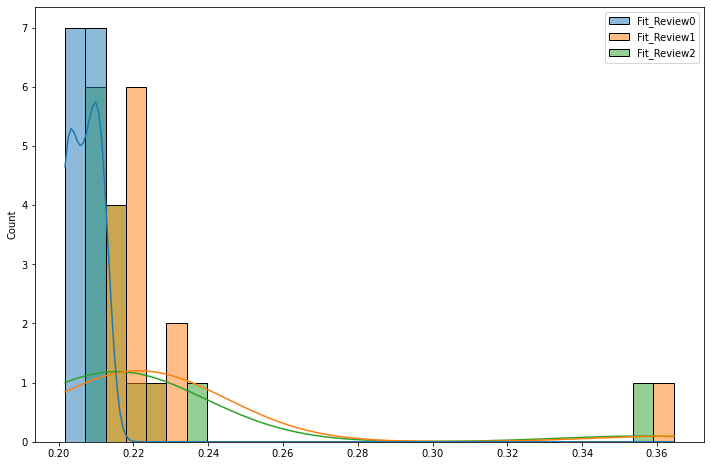

In [1272]:
# Input 
keywords = input('Input keywords: ')

# Preprocess
keywords = [word_to_lemma(remove_extraw_t_n(case_punc(expand_contraction(acro_expand(keywords)))))]
# Identify cluster based on TFIDF
kw_tfidf = tfidf.transform(keywords)
kw_cluster_t = kmeans_tfidf.predict(kw_tfidf)

# Data from cluster
cluster_data = final_data.loc[final_data.cluster_tfidf == kw_cluster_t[0], :].reset_index(drop=True)
X_cl_tfidf = X_tfidf[final_data.cluster_tfidf == kw_cluster_t[0]]
# Sampling from cluster data
num_to_review = 15
# Get nearest neighbors within cluster
indices = np.array(get_neigh_dist(X_cl_tfidf, kw_tfidf, num_to_review)).T[0]
distances = np.array(get_neigh_dist(X_cl_tfidf, kw_tfidf, num_to_review)).T[1]
cluster_sample = cluster_data.iloc[list(indices), :].copy()

# For computing 'fit' probability
def prob_fun(x, avg, std):
    # Probability of normal distribution
    return norm.pdf(x, loc=avg, scale=std)
# Get 'fit' from distances around keyword
cluster_sample['fit'] = prob_fun(distances, 0, np.mean(distances))
# For recording results for each ranking iteration
iterations = cluster_sample.to_numpy()

# Display results
pd.set_option('max_colwidth', 200)
display(cluster_sample.iloc[:, 1:])
# Initialize and loop counter
top_choice = cluster_sample.index[0]
loop = 0
# Initialize manual review
man_review = True
while man_review:  
    # Manual review
    inp = input('Enter the index number of the best candidate: ')          
    # Manual review loop stops when best candidate is at top of list
    if int(inp) == top_choice and loop != 0:
        break           
    # Manual review continues
    else:       
        inpu = int(inp)      
        # Get nearest neighbors
        indices = np.array(get_neigh_dist(X_cl_tfidf, X_cl_tfidf[inpu], num_to_review)).T[0]
        distances = np.array(get_neigh_dist(X_cl_tfidf, X_cl_tfidf[inpu], num_to_review)).T[1]      
        # Enter rows into dataframe using NN indices
        cluster_sample = cluster_data.iloc[list(indices), :].copy()
        # Compute and enter rankings into dataframe using NN distances from starred candidate
        cluster_sample['fit'] = prob_fun(distances, distances[0], np.mean(distances[1:]))
        # Append new top num_to_review to record iteration
        if iterations.ndim == 2:
            iterations = np.stack((iterations, cluster_sample.sort_values(by='fit').to_numpy()), axis=-1)
        else:
            iterations = np.concatenate((iterations, 
                                         cluster_sample.sort_values(by='fit').to_numpy()
                                         .reshape((num_to_review, 4, 1))), axis=-1)           
        # Update top choice and loop counter for next iteration
        top_choice = cluster_sample.index[0]
        loop += 1       
        # Display new top num_to_review
        display(cluster_sample.iloc[:, 1:])        
pd.reset_option('max_colwidth')

# Write history of 'fit' into dataframe
search_history = pd.DataFrame(iterations[:,-1], dtype='float')
search_history.columns = [f'Fit_Review{c}' for c in search_history.columns]
# Plot histograms from history for neighbors around ideal candidate
print('Distributions of nearest neighbors:')
plt.figure(figsize = (12,8))
g = sns.histplot(search_history.iloc[1:, :], kde=True)
plt.show()